# Курсовой проект 
по дисциплине "Обработка естественного языка"

## Предсказание оценки фильма по рецензиям пользователей кинопоиска 

Выполнил студент: Смирнова Татьяна Андреевна

In [2]:
# Активируем библиотеки
import os
from os import listdir
import re
import pandas as pd
import requests
import xmltodict
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU, ConvLSTM2D,MaxPooling1D, Conv1D, Flatten, Bidirectional, SpatialDropout1D, Dropout
import tensorflow as tf

In [3]:
# Задаем рабочую папку
path = 'X:/Magister/S4103/Семестр 3/КР/dataset'
os.chdir(path)

In [10]:
# В качестве входных данных был использован 
# набор данных «Kinopoisk's movies reviews» из kaggle контеста:
# https://www.kaggle.com/datasets/mikhailklemin/kinopoisks-movies-reviews
# и сайт кинопоиска для получения рейтингов.

# Это коллекция рецензий пользователей на фильмы с сайта kinopoisk.ru
# Она состоит из трех папок с положительными (pos), 
# отрицательными(neg) и нейтральными рецензиями(neu), 
# которых 87138, 19827 и 24704 штук соответственно. 
# То есть общее количество рецензий - 131669.

dirs = ['neg', 'neu', 'pos']

# Каждая рецензия представляет из себя файл в соответствующей папке. 
# Она названа таким образом, 
# что 1-я часть — это идентификатор фильма на kinopoisk.ru, 
# а 2-я часть — номер рецензии. 
# Например, 306-15.txt означает, 
# что идентификатор фильма — 305, а номер обзора — 15.

# Создадим функцию для получения данных из файлов

def get_data(dir_name):
    res = []
    dir_path = path + '/' + dir_name + '/'
    files = listdir(dir_path)
    for file in files:
        with open(dir_path  + file, encoding='utf-8') as f:
                content = " ".join([l.rstrip("\n") for l in f])
                name = re.sub(".*/", "", f.name)
                name = re.sub(".txt", "", name)
                kinopoisk_id = name.split("-")[0]
                review_id = name.split("-")[1]
                
                res.append([dir_name, kinopoisk_id, review_id, content])
    return res

# Создадим функцию получения от кинопоиска рейтингов по id фильма

def get_ratings(kinopoisk_id):
    film_id = kinopoisk_id
    url = 'https://rating.kinopoisk.ru/'+ str(film_id) + '.xml'
    r = requests.get(url)
    parsed = xmltodict.parse(r.content)
    kp_rating = parsed['rating']['kp_rating']['#text']
    return kp_rating

In [11]:
# Получим данные из папок
res = []

for dir_name in dirs:
     res.extend(get_data(dir_name))

In [39]:
len(res)

131669

In [43]:
# Конвертируем полученные данные и рейтинги Кинопоиска в один датафрейм.

df = pd.DataFrame()
kinopoisk_ids = set([result[1] for result in res])
rating = dict([[kid, get_ratings(kid)] for kid in kinopoisk_ids])

In [45]:
arr = []
for result in res:
    arr.append([result[0], result[1], result[2], result[3], rating[result[1]]])

In [46]:
df = pd.DataFrame(arr, columns=['status', 'kinopoisk_id', 'review_id', 'content', 'kp_rating'])

In [48]:
df

,status,kinopoisk_id,review_id,content,kp_rating
0,neg,1000083,0,В 2003-ем году под руководством малоизвестного...,4.9
1,neg,1000083,1,"Грустно и печально. Грустно от того, что довол...",4.9
2,neg,1000125,3,Давным-давно Кира Найтли ворвалась на экран от...,6.826
3,neg,1000125,4,"Я, в общем, ничего против уравновешенного феми...",6.826
4,neg,1000125,6,"Измена — один из сюжетов, который всегда будет...",6.826
...,...,...,...,...,...
131664,pos,998790,0,Это одна из самых впечатляющих дорам просмотре...,7.842
131665,pos,998790,1,До сих пор пребываю под огромным впечатлением ...,7.842
131666,pos,998791,1,"Муза французского перверсиониста Мандико, - Ло...",6.118
131667,pos,99912,0,"Как в капле воды отражается мир, так в этом фи...",7.514


c:\users\pro10\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='status', ylabel='count'>

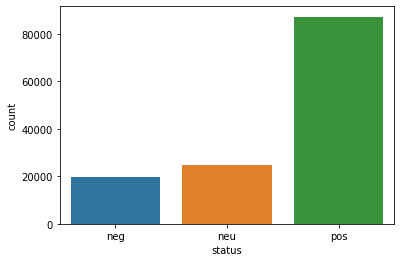

In [93]:
sns.countplot(df['status'])

c:\users\pro10\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='kp_rating', ylabel='count'>

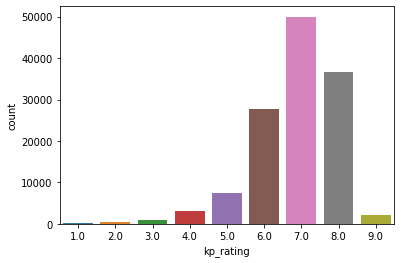

In [94]:

sns.countplot(pre_df['kp_rating'].round())

In [126]:
# Проверим на налчие пустых значений и типы столбцов
pre_df = df
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131669 entries, 0 to 131668
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        131669 non-null  object
 1   kinopoisk_id  131669 non-null  object
 2   review_id     131669 non-null  object
 3   content       131669 non-null  object
 4   kp_rating     131669 non-null  object
dtypes: object(5)
memory usage: 5.0+ MB


In [ ]:
# Изменим тип столбцов
pre_df = pre_df.astype({'status': str, 'kinopoisk_id': int, 'review_id': int, 
                'content': str, 'kp_rating': float})

In [213]:
pre_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128741 entries, 0 to 128740
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   content    128741 non-null  object 
 1   kp_rating  128741 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.0+ MB


In [129]:
# Выведим описание данных

pre_df.describe(include='all')

,status,kinopoisk_id,review_id,content,kp_rating
count,131669,1.316690e+05,131669.000000,131669,131669.000000
unique,3,NaN,NaN,131572,NaN
top,pos,NaN,NaN,"Что вы будете делать, если попадёте в тюрьму н...",NaN
freq,87138,NaN,NaN,2,NaN
mean,NaN,3.532794e+05,23.962261,NaN,6.691671
std,NaN,3.222911e+05,26.336018,NaN,1.445674
min,NaN,3.060000e+02,0.000000,NaN,0.000000
25%,NaN,4.704000e+04,3.000000,NaN,6.241000
50%,NaN,2.834180e+05,13.000000,NaN,6.957000
75%,NaN,5.722300e+05,38.000000,NaN,7.592000


In [8]:
# Рейтинг равен 0, когда нет данных на кинопоиске о нем.
# Удалим такие фильмы.
pre_df = pre_df[(pre_df['kp_rating'] != 0)]

In [9]:
# Округлим рейтинг до одного значения после запятой.

pre_df['kp_rating'] = pre_df['kp_rating'].round(1)

In [10]:
# Сделаем данные в рандомном порядке
pre_df = pre_df.sample(frac=1)

In [13]:
# Удалим столбцы 'status', 'kinopoisk_id','review_id', для предсказывания они не понадобятся
pre_df = pre_df.drop(['status', 'kinopoisk_id','review_id'], axis=1)

In [14]:
#  Удалим дубликаты
pre_df = pre_df.drop_duplicates(subset=['content', 'kp_rating'])

In [15]:
pre_df.describe(include='all')

,content,kp_rating
count,128741,128741.000000
unique,128740,NaN
top,Сегодня хочу поделиться с вами впечатлениями о...,NaN
freq,2,NaN
mean,NaN,6.838127
std,NaN,1.063905
min,NaN,1.100000
25%,NaN,6.300000
50%,NaN,7.000000
75%,NaN,7.600000


In [16]:
# Почистим текст от лишних символов

def textFormat(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = str.replace(text,'ё','е')
    text = text.replace(r'[a-z]+', '')
    text = text.replace(r'\<[^>]*\>', '')
    text = re.sub(r'\d+', '', text)
    text = re.sub("[^а-я -]", "", text)
    text = text.strip()
    return text

In [17]:
pre_df['content'] = pre_df['content'].apply(textFormat)

In [18]:
pre_df

,content,kp_rating
46834,фильм братство крови - это стандартный мало-бю...,3.7
64235,великолепный фильм в самых лучших традициях ам...,7.2
128480,когда я был еще мал свои лучшие дни я проводил...,7.2
118854,в преддверии нового года в воздухе чувствуется...,4.5
62696,очередной америкосовский мульт студии дисней з...,8.1
...,...,...
75089,этот крепкий китайский детектив мне почему-то ...,6.8
71324,котточнее кот в шляпе представляет вашему вним...,4.6
47855,очень нежное трогательное кино и слова эти ска...,6.8
100397,если честно когда я шла в кино предполагала чт...,6.6


In [222]:
# Преобразуем к TF-IDF матрице, используя TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=5)
X = vectorizer.fit_transform(pre_df['content']) 

In [223]:
# Разделяем отклики
y = pre_df['kp_rating']

In [224]:
# Разделяем на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 2023)  

In [161]:
print(len(y_train))
print(len(y_test))

86256
42485


In [225]:
# Обучаем модель линейной регрессии

linReg = LinearRegression().fit(X_train, y_train)

In [227]:
# Предсказываем

y_pred = linReg.predict(X_test)

In [228]:
# Результаты
print(mean_squared_error(y_test, y_pred, squared=False))
print(r2_score(y_test, y_pred))

1.0239415219958736
0.0902717081860539


In [6]:
# Максимальное количество используемых слов
MAX_NB_WORDS = 10000
# Максимальная длина всех последовательностей 
MAX_SEQUENCE_LENGTH = 200

EMBEDDING_DIM = 200

# Выполним токенизацию
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(pre_df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 622374 unique tokens.


In [7]:
X = tokenizer.texts_to_sequences(pre_df['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Y = pre_df['kp_rating']
print('Shape of label tensor:', Y.shape)

Shape of data tensor: (128741, 200)
Shape of label tensor: (128741,)


In [8]:
X_train, X_test, y_train, y_test= train_test_split(X, Y, test_size=0.33, random_state = 2023)

In [9]:
class CheckCallback(tf.keras.callbacks.Callback):
    def __init__(self):
      super(CheckCallback, self).__init__()
      self.df_test_array_summary = pd.DataFrame()  # summary

    def on_epoch_end(self, epoch, logs=None):
        self.df_test_array_summary = self.df_test_array_summary.append({'test_error':mean_squared_error(y_test, self.model.predict(X_test), squared=False), 'loss':logs["loss"]},ignore_index=True)

In [10]:
plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    x = range(1, len(loss) + 1)

    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training and validation loss')
    plt.legend()

In [26]:
# Simple net

model1 = Sequential()
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(Flatten())
model1.add(Dense(1024, activation='relu'))
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          2000000   
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 1024)              40961024  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 43,486,337
Trainable params: 43,486,337
No

In [28]:
epochs = 5
batch_size = 1024

callback_training = CheckCallback()

history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])

Epoch 1/5
76/76 [==============================] - 132s 2s/step - loss: 0.5714 - mse: 0.5714 - val_loss: 0.9117 - val_mse: 0.9117
Epoch 2/5
76/76 [==============================] - 135s 2s/step - loss: 0.3401 - mse: 0.3401 - val_loss: 0.9756 - val_mse: 0.9756
Epoch 3/5
76/76 [==============================] - 137s 2s/step - loss: 0.2344 - mse: 0.2344 - val_loss: 0.9776 - val_mse: 0.9776
Epoch 4/5
76/76 [==============================] - 138s 2s/step - loss: 0.1929 - mse: 0.1929 - val_loss: 0.9740 - val_mse: 0.9740
Epoch 5/5
76/76 [==============================] - 137s 2s/step - loss: 0.1736 - mse: 0.1736 - val_loss: 0.9849 - val_mse: 0.9849


In [29]:
callback_training.df_test_array_summary

,test_error,loss
0,0.949040,0.571383
1,0.983290,0.340144
2,0.984455,0.234366
3,0.982281,0.192878
4,0.987374,0.173589


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


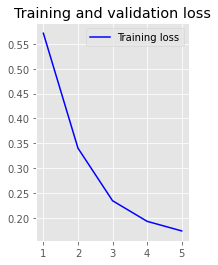

In [32]:
plot_history(history)

In [33]:
# Conventional nn
model1 = Sequential()
model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model1.add(Conv1D(1024, 7, activation='relu',padding='same'))
model1.add(MaxPooling1D())
model1.add(Conv1D(1024, 5, activation='relu',padding='same'))
model1.add(MaxPooling1D())
model1.add(Conv1D(1024, 3, activation='relu',padding='same'))
model1.add(MaxPooling1D())
model1.add(Flatten())
model1.add(Dense(512, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(1))
model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          2000000   
                                                                 
 conv1d (Conv1D)             (None, 200, 1024)         1434624   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 100, 1024)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 100, 1024)         5243904   
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 1024)         0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 50, 1024)         

In [35]:
epochs = 1
batch_size = 1024

callback_training = CheckCallback()

history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])

76/76 [==============================] - 3452s 46s/step - loss: 1.4530 - mse: 1.4530 - val_loss: 0.8288 - val_mse: 0.8288


In [36]:
mean_squared_error(y_test, model1.predict(X_test), squared=False)

0.9094062763625099

In [37]:
history.history

{'loss': [1.4530038833618164],
 'mse': [1.4530038833618164],
 'val_loss': [0.8287543654441833],
 'val_mse': [0.8287543654441833]}

In [38]:
callback_training.df_test_array_summary

,test_error,loss
0,0.909406,1.453004


In [ ]:
# Ensemble of simple nn

In [15]:
def model_g_3_easy_create():
  model1 = Sequential()
  model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model1.add(Flatten())
  model1.add(Dense(100, activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(1))
  model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model1

In [16]:
epochs = 1
batch_size = 1024

callback_training = CheckCallback()

array_model_g_3 = []

for i in range(10):
  model1 = model_g_3_easy_create()
  history = model1.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1, callbacks=[callback_training])
  array_model_g_3.append(model1)

76/76 [==============================] - 26s 340ms/step - loss: 3.7844 - mse: 3.7844 - val_loss: 0.8400 - val_mse: 0.8400


In [17]:
array_model_g_3

In [18]:
callback_training.df_test_array_summary

,test_error,loss
0,0.923767,4.240938
1,0.908891,3.865887
2,0.909972,3.658254
3,0.912624,3.964950
4,0.914957,4.274889
5,0.903046,3.936624
6,0.917832,4.164686
7,0.907775,3.772516
8,0.912637,3.809041
9,0.913946,3.784428


In [19]:
df_g_3_predict = pd.DataFrame({"model_0" : array_model_g_3[0].predict(X_test).flatten()})

for i in range(1,10):
  df_g_3_predict.insert(0, "model_" + str(i), pd.DataFrame(array_model_g_3[i].predict(X_test).flatten()), True) 

In [20]:
results_with_number_of_model = pd.DataFrame()

for i in range(1, 10):
  temp = df_g_3_predict["model_0"]
  for j in range(1, i+1):
    temp = temp + df_g_3_predict["model_" + str(i)]
  temp = temp / (int(j)+1)
  df_g_3_predict['model_mean_' + str(i)] = temp
  results_with_number_of_model = results_with_number_of_model.append({'number':(int(j)+1), 'error':mean_squared_error(y_test, temp, squared=False)},ignore_index=True)

In [21]:
results_with_number_of_model

,number,error
0,2.0,0.907455
1,3.0,0.906786
2,4.0,0.907083
3,5.0,0.910819
4,6.0,0.901026
5,7.0,0.914856
6,8.0,0.905557
7,9.0,0.910393
8,10.0,0.911723


In [23]:
# Ensemble of conventional nn

def model_g_4_easy_create():
  model1 = Sequential()
  model1.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
  model1.add(Conv1D(1024, 7, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Conv1D(1024, 5, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Conv1D(1024, 3, activation='relu',padding='same'))
  model1.add(MaxPooling1D())
  model1.add(Flatten())
  model1.add(Dense(512, activation='relu'))
  model1.add(Dropout(0.2))
  model1.add(Dense(1))
  model1.compile(loss='mse', optimizer='adam', metrics=['mse'])
  return model1